# CMIP6 GSAT overview

Plot global mean near-surface air temperature for CMIP6 models.

### Step 1: call external script to pre-calculate the global mean for models

- example below restricted to one model 

In [ ]:
!/home/dkrz/k202015/Mili/calculate_GSAT_CMIP6-part.run

In [ ]:
# content of script calculate_GSAT_CMIP6-part.run:
for file in "$path"/CMIP6/ScenarioMIP/*/*/ssp245/r*/Amon/tas/g*/v201*/tas_Amon_*_ssp245_r*_g*_*.nc; do
    IFS='/' read -r -a array <<< "$file"
    version="${array[14]}"
    # echo $version
    var_file_name=$file #${file/sit/sic} #replace sit with sic
    file_name=${file##*/} # removes leading ./
    #file_name=${file_name/sit_OImon_/} # remove sit_OImon_ from filename
    file_name=${file_name%.nc} # remove .nc from end
    echo "$file_name" >> conversion.txt
    echo $file_name
    filepath="$outpath"/CMIP6/ssp245/all
    mkdir -p $filepath
    outfile=${filepath}/${file_name}_${version}_globalmean.nc
    if [ ! -f $outfile ]; then
        cdo fldmean $var_file_name $outfile
    else
        echo $outfile exists. Skipping...
    fi
done


In [1]:
import matplotlib.pyplot as plt
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
import numpy as np
from scipy.io import netcdf
import pandas as pd
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()
import xarray as xr
# import random
import os
# import copy

# from datetime import timedelta
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)},font_scale=1.5)

sns.set_style("white")
# sns.set_style("whitegrid")

from pprint import pprint
from tqdm import tqdm

# Import Cdo-py
import cdo
cdo = cdo.Cdo() # change this to a directory in your scratch

# !cdo -V
# !which python

plotdir = './plot/CMIP6_overview/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
    
    
opacity=0.2

# IPCC colors
color_119=[30/255,150/255,132/255]
color_119_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_119]
color_126=[29/255,51/255,84/255]
color_126_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_126]
color_245=[155/255,135/255,12/255]
color_245_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_245]
color_370=[242/255,17/255,17/255]
color_370_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_370]
color_585=[132/255,11/255,34/255]
color_585_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_585]
color_historical = [160/255,160/255,160/255]
color_historical_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_historical]


In [6]:
# data paths
datdir_hist='/work/ik1017/Test/CMIP6_GSAT_part/CMIP6/historical/all/'
datdir_ssp245='/work/ik1017/Test/CMIP6_GSAT_part/CMIP6/ssp245/all/'

In [3]:
# some global settings
ymin = -2
ymax = 5

# plotting options (choose reference period to compute anomalies)
refperiod_start = 1995
refperiod_end   = 2014
piperiod_start  = 1850
piperiod_end    = 1900

## HadCRUT4

In [7]:
# Observed temperature:
f_HadCRU    = netcdf.netcdf_file('./data/HadCRUT.4.6.0.0.median_means.nc')
HadCRU_year = f_HadCRU.variables['time'][:]
idrHad      = np.where((HadCRU_year >= refperiod_start) & (HadCRU_year <= refperiod_end))
HadCRU_t    = f_HadCRU.variables['temperature_anomaly'][:,0,0]-np.mean(f_HadCRU.variables['temperature_anomaly'][idrHad,0,0])

# compute anomalies w.r.t. preindustrial
idrHad_pi      = np.where((HadCRU_year >= piperiod_start) & (HadCRU_year <= piperiod_end))
HadCRU_t_pi    = f_HadCRU.variables['temperature_anomaly'][:,0,0]-np.mean(f_HadCRU.variables['temperature_anomaly'][idrHad_pi,0,0])



#--------------------------------------------------------------------------
HadCRU_time = pd.date_range('1850-01-01', periods=len(HadCRU_year), freq='A-JUL') #+ pd.DateOffset(days=-30)

/sw/spack-rhel6/anaconda3-2020.02-dqbodz/lib/python3.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


### historical

In [9]:
files_hist = os.listdir(datdir_hist)
files_hist.sort()
# print(files_hist)
# filter for r1
subs = '_r1i1'
# using list comprehension  
# to get string with substring  
r1_files_hist = [model for model in files_hist if subs in model] 
  
# printing result  
# pprint(r1_files_hist)

# extract model names
models = [filename.split('_')[2] for filename in r1_files_hist]
# remove duplicate names
unique_models = list(dict.fromkeys(models))
# pprint(unique_models)

# remove E3SM-1-1 model because it has two years with wrong data in the historical period (GSAT below ~ -30 deg C)
#unique_models.remove('E3SM-1-1')
#unique_models.remove('E3SM-1-1-ECA')



# identify highest version numer
modelversions_latest_hist = {}
for model in unique_models:
    model_files_hist = [filename for filename in r1_files_hist if model in filename]
#     print(model_files_hist)
    versions = [filename.split('_')[7] for filename in model_files_hist]
    #     if not [filename for filename in model_files_hist if '185001' in filename]:
    versions.sort()
    modelversions_latest_hist[model]=versions[-1]

# pprint(modelversions_latest_hist)

In [10]:
# load files
# historical

# initialise array:
operator = '-yearmean -mergetime'
ds_hist = []
loop = 0
for model in tqdm(unique_models):
    # find all files for latest version
    model_files = [filename for filename in r1_files_hist if model in filename]
    latest_model_files = [filename for filename in model_files if modelversions_latest_hist[model] in filename]
    ifile = datdir_hist + '*' + model + '*' + modelversions_latest_hist[model] + '*'
    model_timeseries = cdo.addc('0',input=operator+' '+ifile, returnXArray='tas').squeeze()
    # add modelname as attribute
    model_timeseries.attrs['model'] = model
    # some models don't have a readable time axis (replacing with time series derived from first year and length of time axis)
    firstyear = str(model_timeseries['time'][0].values)[0:4]
    time_length = model_timeseries.size
    model_timeseries.coords['time'] = pd.date_range(firstyear + '-01-01', periods=time_length, freq='A-JUL')
    # some models have historical simulations beyond 2014
    model_timeseries = model_timeseries.loc['1850-01-01':'2014-12-31']
    # remove height coords if they exist. Causes problems with xr.concat
    if 'height' in model_timeseries.coords:
        del model_timeseries['height']

    ds_hist.append(model_timeseries)

100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


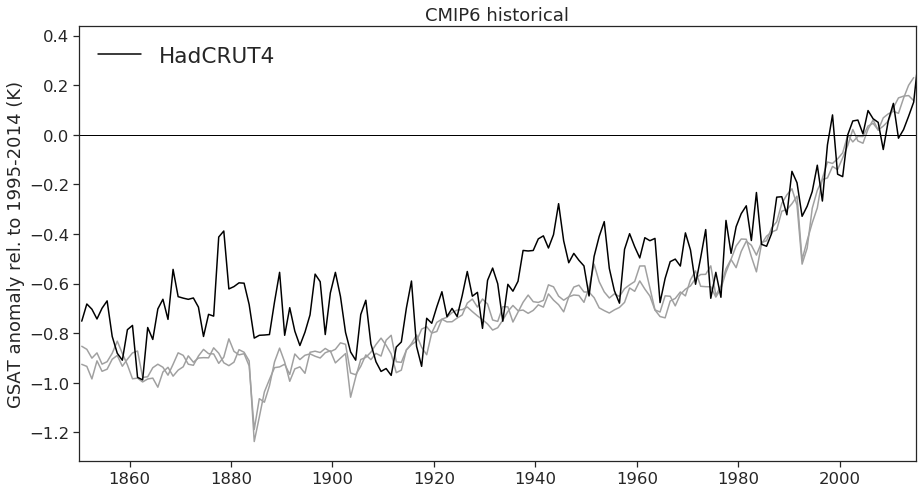

In [11]:
fig, axes = plt.subplots(1,1, figsize=(15,8))

# loop over all models, compute anomaly w.r.t. reference period (default is 1995-2014)
for array in ds_hist:
    axes.plot(array['time'],array-array.loc[str(refperiod_start)+'-01-01':str(refperiod_end)+'-12-31'].mean(dim='time'), color=color_historical, label='') 
# for plotting each model with an individual color and label, use this:
#     axes.plot(array['time'],array-array.loc[str(refperiod_start)+'-01-01':str(refperiod_end)+'-12-31'].mean(dim='time'), label=array.attrs['model']) 





# add observations
axes.plot(HadCRU_time,HadCRU_t,color='black',label='HadCRUT4')

# add a zeroline
x_pos1=np.datetime64('1850-01-01')
x_pos2=np.datetime64('2100-12-31')
axes.plot([x_pos1,x_pos2],[0,0], color='black',linewidth=1)


legend = axes.legend(loc='upper left', shadow=True, fontsize='large',ncol=2,frameon=False)
axes.set_xlim([pd.Timestamp('1850-01-01'),pd.Timestamp('2015-01-01')])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True) # labels along the bottom edge are off



axes.set_ylabel('GSAT anomaly rel. to '+str(refperiod_start)+'-'+str(refperiod_end)+' (K)')
axes.set_title('CMIP6 historical')

plt.savefig(plotdir+'CMIP6_historical.pdf', bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)

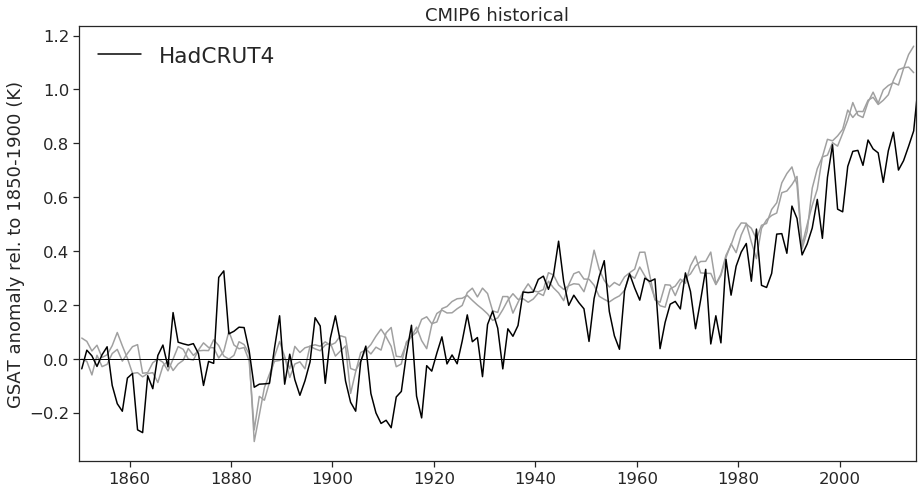

In [12]:
# Same plot as before, but compute anomalies relative to preindustrial period

fig, axes = plt.subplots(1,1, figsize=(15,8))

for array in ds_hist:
    axes.plot(array['time'],array-array.loc[str(piperiod_start)+'-01-01':str(piperiod_end)+'-12-31'].mean(dim='time'), color=color_historical, label='')


# add observations
axes.plot(HadCRU_time,HadCRU_t_pi,color='black',label='HadCRUT4')



# zeroline
x_pos1=np.datetime64('1850-01-01')
x_pos2=np.datetime64('2100-12-31')
axes.plot([x_pos1,x_pos2],[0,0], color='black',linewidth=1)


legend = axes.legend(loc='upper left', shadow=True, fontsize='large',ncol=2,frameon=False)
axes.set_xlim([pd.Timestamp('1850-01-01'),pd.Timestamp('2015-01-01')])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True) # labels along the bottom edge are off




axes.set_ylabel('GSAT anomaly rel. to '+str(piperiod_start)+'-'+str(piperiod_end)+' (K)')
axes.set_title('CMIP6 historical')

plt.savefig(plotdir+'historical_ref1850.pdf', bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)